# Verifier의 성능 확인

Verifier가 선택한 답이 맞을 확률이 높은 것이 맞는지?

In [1]:
import os; os.chdir("../")
import sys; sys.path.append('scripts')

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import yaml
import matplotlib.pyplot as plt
import torch
from datasets import load_from_disk

from transformers import (
    BitsAndBytesConfig,
    AutoModelForCausalLM, AutoTokenizer,
    
)
from tqdm import tqdm
from utils import HF_NAME_MAP
from utils import set_seed, init_tokenizer, validate_args, _extract_answer

config_path = "configs/basic.yml"
with open(config_path, 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


def get_likelihood(model, prompt_tokens, label_tokens):
    """
    Compute the likelihood for multiple label tokens given a shared prompt.

    Args:
        model: The causal language model.
        prompt_tokens (torch.Tensor): The prompt tokens of shape (1, q_tokens).
        label_tokens (torch.Tensor): The label tokens of shape (n_samples, a_tokens).

    Returns:
        torch.Tensor: A tensor of shape (n_samples,) containing the log-likelihood for each sample.
    """
    n_samples = label_tokens.size(0)
    q_tokens = prompt_tokens.size(1)

    # Repeat the prompt tokens for each label
    repeated_prompt_tokens = prompt_tokens.repeat(n_samples, 1).to(label_tokens.device)  # Shape: (n_samples

    # Concatenate prompt and label tokens
    input_tokens = torch.cat([repeated_prompt_tokens, label_tokens], dim=1)  # Shape: (n_samples, q_tokens + a_tokens)

    with torch.no_grad():
        outputs = model(input_tokens)
        logits = outputs.logits.detach().cpu()  # Shape: (n_samples, seq_length, vocab_size)

    # Extract logits corresponding to label tokens
    label_start_idx = q_tokens  # Labels start after the prompt
    label_logits = logits[:, label_start_idx - 1:-1, :]  # Shape: (n_samples, a_tokens, vocab_size)

    # Compute log-probabilities for the label tokens
    log_probs = torch.log_softmax(label_logits, dim=-1)  # Shape: (n_samples, a_tokens, vocab_size)
    label_log_probs = log_probs.gather(2, label_tokens.unsqueeze(-1)).squeeze(-1)  # Shape: (n_samples, a_tokens)

    # Sum log-probabilities over all label tokens for each sample
    # total_log_likelihood = label_log_probs.sum(dim=1)  # Shape: (n_samples,)
    total_log_likelihood = label_log_probs.mean(dim=1)  # Shape: (n_samples,)

    return total_log_likelihood.detach().cpu()

In [3]:
model_name = "sft_llama-1b"
task_name = "gsm8k"
model_type, pt_name = model_name.split("_")
hf_name = HF_NAME_MAP[pt_name]

tokenizer = AutoTokenizer.from_pretrained(hf_name)
init_tokenizer(tokenizer)

dset = load_from_disk("data/ver_sft_llama-1b_gsm8k/test")

# verifier_path = f"models/veri_{model_name}_{task_name}"
# verifier_path = f"models/{model_name}_{task_name}"
paths = [
    "/home/chanwoo/chanwoo/repo/verifier/models/verifier/checkpoints/veri_sft_llama-1b_gsm8k/checkpoint-13149/target",
    f"models/{model_name}_{task_name}",
]


In [4]:
# for verifier_path in paths:
#     verifier = AutoModelForCausalLM.from_pretrained(
#         verifier_path,
#         quantization_config=BitsAndBytesConfig(**config['qt']),
#         **config['model'][pt_name]
#     )
#     results = []

#     for idx in tqdm(range(300)):
#         chosen_lik = get_likelihood(
#             verifier, 
#             tokenizer(dset["prompt"][idx], return_tensors='pt').input_ids,
#             tokenizer(dset["chosen"][idx], return_tensors='pt').input_ids
#         )
#         rejected_lik = get_likelihood(
#             verifier, 
#             tokenizer(dset["prompt"][idx], return_tensors='pt').input_ids,
#             tokenizer(dset["rejected"][idx], return_tensors='pt').input_ids
#         )
#         res = chosen_lik - rejected_lik > 0

#         # print(f"Result for idx={idx}")
#         # print(f"Prompt: {dset['prompt'][idx]}")
#         # print("\n")
#         # print(f"Chosen: {dset['chosen'][idx]}")
#         # print(f"Chosen Likelihood: {chosen_lik}")
#         # print("\n")
#         # print(f"Rejected: {dset['rejected'][idx]}")
#         # print(f"Rejected Likelihood: {rejected_lik}")
#         res = chosen_lik - rejected_lik > 0

#         results.append(res)

#     print(f"Model: {verifier_path}")
#     print(f"Accuracy: {sum(results) / len(results)}")

In [13]:
import re
from datetime import datetime

# verifier_path = "/home/chanwoo/chanwoo/repo/verifier/models/verifier/checkpoints/veri_sft_llama-8b_gsm8k/checkpoint-3600/target"
# verifier_path = "models/verifier/checkpoints/veri_sft_llama-1b_gsm8k/checkpoint-13149/target"
verifier_path = "/home/chanwoo/chanwoo/repo/verifier/models/verifier/checkpoints/veri_sft_llama-1b_gsm8k/checkpoint-13149/target"
# verifier_path = "/home/chanwoo/chanwoo/repo/verifier/models/verifier/checkpoints/veri_sft_llama-8b_gsm8k/checkpoint-8000/target"
verifier = AutoModelForCausalLM.from_pretrained(
    verifier_path,
    quantization_config=BitsAndBytesConfig(**config['qt']),
    **config['model'][pt_name]
)


gen_model = AutoModelForCausalLM.from_pretrained(
    f"models/{model_name}_{task_name}",
    quantization_config=BitsAndBytesConfig(**config['qt']),
    **config['model'][pt_name]
)

def parse_log(file_path, start_time_str):
    start_time = datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S")
    results = []

    with open(file_path, "r") as log_file:
        lines = log_file.readlines()

    parsing = False
    current_entry = {}

    for line in lines:
        # Check if we should start parsing after the specific time
        match_time = re.match(r"\[(.*?)\]", line)
        if match_time:
            log_time = datetime.strptime(match_time.group(1), "%Y-%m-%d %H:%M:%S,%f")
            if log_time >= start_time and "Starting Evaluate script" in line:
                parsing = True


        if not parsing:
            continue

        # Parse Best answer index
        if "Best answer index" in line:
            current_entry["Best answer index"] = int(re.search(r"Best answer index (\d+)", line).group(1))

        # Parse Question
        elif "[INFO] - Question:" in line:
            question_match = re.search(r"Question: (.*)", line)
            if question_match:
                current_entry["Question"] = eval(question_match.group(1))  # Safely parse list

        # Parse Prediction
        elif "[INFO] - Prediction:" in line and "INFO" in line:
            prediction_match = re.search(r"Prediction: (.*)", line)
            if prediction_match:
                current_entry["Prediction"] = eval(prediction_match.group(1))  # Safely parse list

        # Parse Answer
        elif "[INFO] - Answer:" in line:
            answer_match = re.search(r"Answer: (.*)", line)
            if answer_match:
                current_entry["Answer"] = eval(answer_match.group(1))  # Safely parse list

        # If all fields are collected, save the entry and reset
        if all(key in current_entry for key in ["Best answer index", "Question", "Prediction", "Answer"]):
            results.append(current_entry)
            current_entry = {}

    return results

# Example usage
log_path = "logs/test_verifier.log"
start_time = "2024-12-09 23:21:33"
parsed_data = parse_log(log_path, start_time)

res = []
for entry in parsed_data:
    # print("Best Answer Index:", entry["Best answer index"])
    # print("Question:", entry["Question"])
    # print("Prediction:", entry["Prediction"])
    # print("Answer:", entry["Answer"])
    # print("-" * 80)
    # break
    try:
        answer_pat = r'####\s*\d+'
        idx = entry["Best answer index"]
        # Extract number(d) in the answer pattern
        pred_answer = re.search(answer_pat, entry["Prediction"][idx]).group(0).split('####')[-1].strip()
        true_answer = re.search(answer_pat, entry["Answer"][0]).group(0).split('####')[-1].strip()
        is_correct = pred_answer == true_answer
        res.append({
            'question': entry["Question"],
            'prediction': entry["Prediction"],
            'answer': entry["Answer"],
            'best_answer_idx': idx,
            'pred_answer': pred_answer,
            'true_answer': true_answer,
            'is_correct': is_correct
        })
    except Exception as e:
        print(e)

In [15]:
res

[]

In [14]:
accuracy = sum([1 for r in res if r['is_correct']]) / len(res)
accuracy

ZeroDivisionError: division by zero

In [7]:
import torch

def _get_likelihood(model, prompt_tokens, label_tokens):
    """
    Compute the likelihood for multiple label tokens given a shared prompt.

    Args:
        model: The causal language model.
        prompt_tokens (torch.Tensor): The prompt tokens of shape (1, q_tokens).
        label_tokens (torch.Tensor): The label tokens of shape (n_samples, a_tokens).

    Returns:
        torch.Tensor: A tensor of shape (n_samples,) containing the log-likelihood for each sample.
    """
    n_samples = label_tokens.size(0)
    q_tokens = prompt_tokens.size(1)

    # Repeat the prompt tokens for each label
    repeated_prompt_tokens = prompt_tokens.repeat(n_samples, 1).to(label_tokens.device)  # Shape: (n_samples

    # Concatenate prompt and label tokens
    input_tokens = torch.cat([repeated_prompt_tokens, label_tokens], dim=1)  # Shape: (n_samples, q_tokens + a_tokens)

    with torch.no_grad():
        outputs = model(input_tokens)
        logits = outputs.logits.detach().cpu()  # Shape: (n_samples, seq_length, vocab_size)

    # Extract logits corresponding to label tokens
    label_start_idx = q_tokens  # Labels start after the prompt
    label_logits = logits[:, label_start_idx - 1:-1, :]  # Shape: (n_samples, a_tokens, vocab_size)

    # Compute log-probabilities for the label tokens
    log_probs = torch.log_softmax(label_logits, dim=-1)  # Shape: (n_samples, a_tokens, vocab_size)
    label_log_probs = log_probs.gather(2, label_tokens.unsqueeze(-1)).squeeze(-1)  # Shape: (n_samples, a_tokens)

    return label_log_probs

In [8]:
import json

with open("data/multi_samples-1b.json", "w") as f:
    json.dump(parsed_data, f)

In [9]:
def is_answer(answer, pred):
    pn, gn = _extract_answer(pred, answer)
    return pn == gn

idx = 20
instruction = "Please calculate the solution step-by-step and conclude the answer with \n#### followed by the result.\nQuestion: "
entry = parsed_data[idx]
print(entry["Question"][0].replace(". ", ".\n"))
print()
print(entry["Answer"][0])
ver_lik = []
total_num_answer = sum([is_answer(entry["Answer"][0], pred) for pred in entry["Prediction"]])
for i in range(len(entry["Prediction"])):
    label_log_probs = _get_likelihood(
        # gen_model, 
        verifier, 
        tokenizer(entry["Question"][0], return_tensors='pt').input_ids,
        tokenizer(entry["Prediction"][i], return_tensors='pt').input_ids
    )
    ver_lik.append(label_log_probs.mean(dim=1))

ver_lik = torch.stack(ver_lik).squeeze()

gen_lik = []

for i in range(len(entry["Prediction"])):
    label_log_probs = _get_likelihood(
        # gen_model, 
        verifier, 
        tokenizer(instruction + entry["Question"][0], return_tensors='pt').input_ids,
        tokenizer(entry["Prediction"][i], return_tensors='pt').input_ids
    )
    gen_lik.append(label_log_probs.mean(dim=1))

gen_lik = torch.stack(gen_lik).squeeze()


print(f"Toal number of answer: {total_num_answer}")
print()
print(ver_lik)
print(ver_lik.argmax())
print()
print(gen_lik)
print(gen_lik.argmax())
print(entry["Prediction"][ver_lik.argmax().item()])

I have 10 liters of orange drink that are two-thirds water and I wish to add it to 15 liters of pineapple drink that is three-fifths water.
But as I pour it, I spill one liter of the orange drink.
How much water is in the remaining 24 liters?

There are 15 x 3/5 = <<15*3/5=9>>9 liters of water from the 15 liters pineapple drink.
After 1 liter of orange drink was spilled, there were 10 - 1 = <<10-1=9>>9 liters of orange drink left.
Out of the 9 liters, 9 x 2/3 = <<9*2/3=6>>6 liters are water.
Thus, there are a total of 9 + 6 = <<9+6=15>>15 liters of water out of the 24 liters.
#### 15


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Toal number of answer: 1

tensor([-1.7667, -2.6694, -2.3818, -2.8700, -4.0533, -2.0333, -3.6551, -2.0791,
        -1.9291, -4.0411, -2.6314, -2.9985, -3.3573, -2.5032, -2.1206, -2.0748])
tensor(0)

tensor([-1.9597, -2.2903, -2.3238, -2.6508, -4.1895, -1.9694, -3.6072, -2.1428,
        -1.8209, -4.2150, -2.6648, -3.1616, -3.1654, -2.4959, -2.3229, -2.3607])
tensor(8)
 
Answer: If one liter of orange drink is two-thirds water, then we have 2/3*10 = <<2/3*10=10>>10 liters of orange drink.
If 1/3 of 15 liters of pineapple drink is water, then we have 15*.5 = <<15*.5=7.5>>7.5 liters of water.
When 1 liter of orange drink is two-thirds water, we can convert this to 1/3*1 = <<1/3*1=1/3>>1/3 liters of water.
Hence, after losing 10 liters of orange drink, there is 10+7.5 = <<10+7.5=17>>17 liters of water in the original orange drink.
#### 17 liters


In [10]:
print((entry["Prediction"][6]))

 
Answer: There are 10 litres/2 + 15 litres/3 = <<10+15=25>>25 litres of water.
25 litres/25 = <<25/25=1.00000000001>>1,000 million millilitres of water.
1 million millilitres = 1000 litres.
Thus, 1,000 - 1,000 = 900 litres of water is left.
#### 900



0 tensor(32.6060)
1 tensor(38.1800)
2 tensor(35.0161)
3 tensor(33.5372)
4 tensor(32.5514)
5 tensor(42.4214)
6 tensor(26.1592)
7 tensor(34.1858)
8 tensor(36.6167)
9 tensor(31.3872)
10 tensor(30.1028)
11 tensor(29.9268)
12 tensor(29.6502)
13 tensor(41.3872)
14 tensor(48.9996)
15 tensor(34.5613)


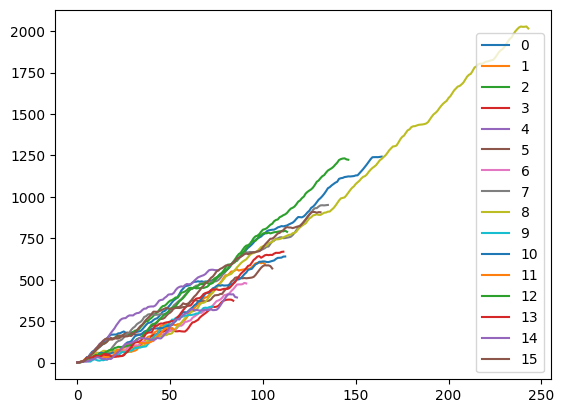

In [11]:
for i in range(16):
    querys = entry["Question"][0]+" "+entry["Prediction"][i]
    with torch.no_grad():
        query = tokenizer(querys, return_tensors='pt').input_ids
        labels = tokenizer(entry["Prediction"][i], return_tensors='pt').input_ids
        logits = verifier(query).logits[:, -labels.size(1):].cpu()
        label_log_probs = logits.gather(2, labels.unsqueeze(-1)).squeeze(-1).squeeze()
        print(i, torch.var(label_log_probs))
        plt.plot(label_log_probs.numpy().cumsum(), label=i)
plt.legend()
plt.show()
    # res = get_batch_logps(logits, labels, label_pad_token_id=tokenizer.pad_token_id)

In [12]:
STOP

NameError: name 'STOP' is not defined

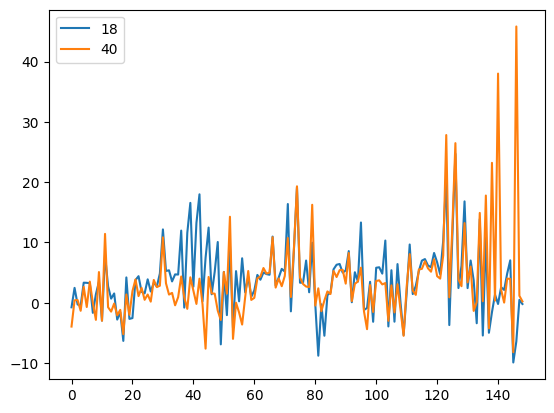

In [ ]:
true_answer = "18"
pred_answer = "40"
label_len = labels.size(1)
answers = tokenizer(true_answer).input_ids[1:]
logit_seq = logits[0, -label_len:, answers].sum(dim=1)
plt.plot(logit_seq.numpy(), label=true_answer)
answers = tokenizer(pred_answer).input_ids[1:]
logit_seq = logits[0, -label_len:, answers].sum(dim=1)
plt.plot(logit_seq.numpy(), label=pred_answer)
plt.legend()
plt.show()

In [ ]:
tokenizer.decode(labels[0,:80], skip_special_tokens=True)

' \nAnswer: Melanie sold 5 x 1/3 = <<5*1/3=2>>2 vacuum cleaners in the green house.\nShe sold a total of 2 + 2 + 4 + 2 = <<2+2+4+2=10>>10 vacuum cleaners to the green house.\nTherefore, she sold 5 - 10 = <<5-'

In [ ]:
def get_batch_logps(
    logits: torch.FloatTensor,
    labels: torch.LongTensor,
    label_pad_token_id: int = -100,
    is_encoder_decoder: bool = False,
):
    """Compute the log probabilities of the given labels under the given logits.

    Args:
        logits: Logits of the model (unnormalized). Shape: (batch_size, sequence_length, vocab_size)
        labels: Labels for which to compute the log probabilities. Label tokens with a value of label_pad_token_id are ignored. Shape: (batch_size, sequence_length)
        label_pad_token_id: The label pad token id.
        is_encoder_decoder: Whether the model is an encoder-decoder model.

    Returns:
        A Tuple of two tensor of shape ((batch_size,), (batch_size,)) containing the sum of log probabilities of the given labels under the given logits in the first tensor and the number of non-masked tokens in the second tensor.
    """
    if logits.shape[:-1] != labels.shape:
        raise ValueError(
            f"Logits (batch and sequence length dim) {logits.shape[:-1]} and labels must have the same shape {labels.shape}."
        )

    if not is_encoder_decoder:
        labels = labels[:, 1:].clone()
        logits = logits[:, :-1, :]
    loss_mask = labels != label_pad_token_id

    # dummy token; we'll ignore the losses on these tokens later
    labels[labels == label_pad_token_id] = 0

    per_token_logps = torch.gather(logits.log_softmax(-1), dim=2, index=labels.unsqueeze(2)).squeeze(2)

    return (per_token_logps * loss_mask).sum(-1)

In [ ]:
a = [' \nAnswer: Each necklace is made to a total length of 25 inches, so each necklace has space for 25 - 8 = <<25-8=17>>17 beads.\nEach sterling silver bead is one-quarter of an inch long, and the necklace is 25 inches long, so there are 1/0.25 = <<1/0.25=4>>4 beads in every inch of the necklace.\nThere are 17 space for 4 beads = <<17*4=68>>68 sterling silver beads per necklace\n#### 68/', ' \nAnswer: Eight topaz gemstones of one-inch length amount to 8 x 1 = <<8*1=8>>8 inches of gemstone.\nThe total length of the necklace less the gemstones equals the silver beads, so the necklace is made to a length of 25 - 8 = <<25-8=17>>17 inches in total from silver beads.\nEach sterling silver bead is one-quarter of an inch in length so she therefore needs to include 17/0.25 = <<17/0.25=68>>68 sterling silver beads in each necklace.\n#### 68\n', ' \nAnswer: In a 25-inch-long necklace with 8 topaz gemstones each 1 inch long, there will be 25-8 = <<25-8=17>>17 inches left for sterling silver beads to fill.\nWith each sterling silver bead taking up one-quarter of an inch of space, she will therefore need to use 17*(1/4) = 4.25 sterling silver beads to fill.\nSince you can’t use half a sterling silver bead, Katerina will use 5 sterling silver beads in each necklace.\n#### 5/', ' \nAnswer: Each topaz necklace is made to a total length of 25 inches, and each topaz is one inch long, which leaves 25-8 = 17 inches of the 25-inch length to be filled with sterling silver beads.\nIf the 17 inch length is made up of sterling silver beads that are each one-quarter of an inch long, then the number of sterling silver beads in 17 inches is 17/ 1/4 = 68/1 = 68 sterling silver beads.\n#### 68 sterling', ' \nAnswer: To create one necklace, Katerina uses 8 one-inch gemstones to a total length of 25 inches so there are 25/8 = 3.125-inch segments.\nEach sterling silver bead takes up 1/4 of an inch per segment. So she needs 1/4 * 3.125 = <<1/4*3.125=0.781>>0.781 sterling silver beads per segment.\nThere are 8 segments per 25-inch necklace so 8 * 0.781 = <<8*0.781=6.264>>6.264 sterling silver beads per 25 inch necklace.\n#### 6.', ' \nAnswer: Since each necklace is made to a total length of 25 inches, then for each necklace, with 8 topaz gemstones at 1 inch each, there remain 25-8*1=<<25-8*1=17>>17 "leftover" inches of string to use on sterling silver beads.\nIf these 17 "leftover" inches of string are used on sterling silver beads that are each a quarter of an inch in length, then Katerina uses 17*4=<<17*4=68>>68 sterling silver beads per necklace.\n#### 68 sterling', ' \nAnswer: Since each necklace is 25 inches long, and each topaz gemstone is 1 inch, then in each necklace, Katerina uses 25-8 = <<25-8=17>>17 pieces of sterling silver beads.\nEach sterling silver bead is 1/4 inch long, so one sterling silver bead will fit 1/4 of the 25-inch length of a necklace, or 25/4 = 6.25.\nTo make a total necklace length of 25 inches, Katerina therefore uses 25/6.25 = 4.0 sterling silver beads of that size, and then uses 3 additional sterling silver beads to fill the length of the gaps between gemstones.\n#### 4.', ' \nAnswer: A necklace 25 inches long will take 25 - 8 = <<25-8=17>>17 inches of beads to make.\nEach one-quarter of an inch bead is 1/4 of an inch long, so for 17 inches, Katerina will need to use 68 sterling silver beads.\n#### 68 sterling', " \nAnswer: There is one inch of space between each one-inch gemstone so 1 + 1 + 1 + 1 + 1 + 1 + 1 + 1 = <<1+1+1+1+1+1+1+1=8>>8 inch space in each necklace.\nThis leaves 25 - 8 = <<25-8=17>>17 inches of sterling silver bead space in each necklace.\nSince each sterling silver bead is 1/4 inch long, then each necklace requires 17 x 1/4 = <<17*1/4=4.25>>4.25 sterling silver beads.\nIf a quarter contains 25 cents and Katerina has 250 quarters, she has 250 x 25 = $<<250*25=6250>>6250 quarters.\nIf each sterling silver bead is 1/4 of an inch, Katerina's 6250 quarters will each have enough sterling silver beads for 6250 x (1/4) = <<6250*(1/4)=1562.5>>1562.5 sterling silver beads.\n#### 1562.", ' \nAnswer: There are 25 - 8 = <<25-8=17>>17 spaces between topaz gemstones on a necklace.\nEach space between gemstones is 1/2 an inch long, so each space needs to be filled with one silver bead, 17 spaces x 1/2 inch = 8.5 silver beads needed.\nSterling silver beads are one-quarter of an inch long, and each space requires a half inch, so they will not all work, so the excess is 1/2 - 1/4 = 1/8.\nA quarter of a bead is 1/4, so 1/8 of a sterling silver bead is 1/4^2 = 1/16 of an inch.\nSo, Katerina will use a 1/16 of a sterling silver bead for every space filled, or 1/8 of a sterling silver bead for every space needed.\n1/8 of a sterling silver bead is 1/4^2 = 1/16 of an inch.\nSo, the 17 spaces will require a total of 1/16*17 = <<1/16*17=1.0625>>1.0625 sterling silver beads.\nTherefore, 1.0625 > 1, and so, she will require 2 sterling silver beads to fill 1.0625 sterling silver beads.\nShe will require 2 sterling silver beads to fill the 1.0625 sterling silver beads needed to fill all the 17 spaces.\nTherefore, she will require 2 * 2 = <<2*2=4>>4 sterling silver beads for all the spaces on 1 necklace.\n#### 4/', ' \nAnswer: Since each necklace is made to a total length of 25 inches, and each gemstone is one inch long, with each bead being one-quarter of an inch long, that means for every two topaz gemstones that Katerina uses, there will be 2*.25 = <<2*.25=0.5>>.5 sterling silver beads of length.25 per topaz gemstone.\nThat means for each topaz gemstone, there are.5 sterling silver beads. So since Katerina uses 8 topaz gemstones per necklace, and for each gemstone there are.5 sterling silver beads, that means she uses 8*.5= <<8*.5=4>>4 sterling silver beads for each topaz gemstone on a topaz necklace.\nShe therefore uses 8 topaz gemstones * 4 sterling silver beads = <<8*4=32>>32 sterling silver beads per topaz necklace she makes.\n#### 32 sterling', ' \nAnswer: A 25-inch necklace would require 25-8 = <<25-8=17>>17 inches between individual gemstones for sterling silver beads.\nA 17-inch necklace would require 17/0.25 = 68 sterling silver beads.\n#### 68 sterling', ' \nAnswer: Each necklace is 25 inches long, and each topaz is 1 inch long, so 25-8 = <<25-8=17>>17 inches remain after for all the topaz gemstones.\nThere is 1/4-inch of silver beads between each 1-inch topaz gemstone, so there are 17 inches of necklaces, and each 1/4-inch sterling silver bead takes up 1/4 x 17 inches = 4 1/4 = 4.25 sterling silver beads per necklace.\n#### 4.', ' \nAnswer: 25-inch long necklace needs 25-8 = <<25-8=17>>17 inches of sterling silver beads.\nIf each sterling silver bead is one-quarter of an inch long, then 1 quarter of an inch = 0.25 inches.\nOne-quarter of an inch is equal to 4 sterling silver beads, so therefore 17 inches of sterling silver beads = 17/0.25 = 68 sterling silver beads per necklace.\n#### 68 sterling', ' \nAnswer: On topaz necklaces, sterling silver beads take up 25 – 8 = <<25-8=17>>17 inches.\nThus, per necklace, Katerina uses 17 inches / (1/4 inch per sterling silver bead) = <<17/(1/4)=68>>68 sterling silver beads.\n#### 68 sterling', ' \nAnswer: As the topaz gemstones in her necklaces are one inch long, and each sterling silver bead is one-quarter of an inch long, this means that one sterling silver bead will fit between every 4 consecutive topaz gemstones.\nTherefore for each necklace that Katerina makes that uses 8 topaz gemstones, she will have 8 / 4 = 2 spaces available for sterling silver beads.\nOne sterling silver bead will fit between every two consecutive topaz gemstones, so each space created by this topaz arrangement will fit one 1 bead.\nIn a necklace, which is 25 inches long, this translates to 1 bead every.1 inch, meaning 25 /.1 = <<25/.1=250>>250 possible space for sterling silver beads.\nSince there are 2 spaces for sterling silver beads per 8 topaz gemstones per necklace, this means there are 2 * 2 = <<2*2=4>>4 spaces available for sterling silver beads in 8 topaz gemstones.\nTherefore, for 8 topaz gemstones, there will fit 250/4 = <<250/4=62>>62 sterling silver beads into a necklace.\n#### 62.\n']
b = ['8 topaz gemstones, at 1 inch per gemstone, contribute a total of 8*1=<<8*1=8>>8 inches to each necklace.\nSince each necklace is 25 inches in length, then there are 25-8=<<25-8=17>>17 inches of space between gemstones.\nSince Katerina uses one-quarter inch sterling silver beads to fill space between gemstones, then she will require 17*4=<<17*4=68>>68 sterling silver beads per necklace.\n#### 68']

In [ ]:
print(a[11])
print(b[0])

 
Answer: A 25-inch necklace would require 25-8 = <<25-8=17>>17 inches between individual gemstones for sterling silver beads.
A 17-inch necklace would require 17/0.25 = 68 sterling silver beads.
#### 68 sterling
8 topaz gemstones, at 1 inch per gemstone, contribute a total of 8*1=<<8*1=8>>8 inches to each necklace.
Since each necklace is 25 inches in length, then there are 25-8=<<25-8=17>>17 inches of space between gemstones.
Since Katerina uses one-quarter inch sterling silver beads to fill space between gemstones, then she will require 17*4=<<17*4=68>>68 sterling silver beads per necklace.
#### 68


In [ ]:
new_dset = {
    "question" : list(reversed(origin['question']))
    "answer" : list(reversed(origin['answer']))
}


['Henry and 3 of his friends order 7 pizzas for lunch. Each pizza is cut into 8 slices. If Henry and his friends want to share the pizzas equally, how many slices can each of them have?',
 'Farmer Brown has 20 animals on his farm, all either chickens or cows. They have a total of 70 legs, all together. How many of the animals are chickens?',
 "Mark's car breaks down and he needs to get a new radiator.  The cost for a new radiator is $400 but he goes to get it at a junk shop and gets it for 80% off.  He then hires a mechanic to install it and it takes 3 hours at $50 an hour.  How much did he pay?",
 'There are some oranges in a basket. Ana spends 3 minutes peeling an orange and Jane spends 4 minutes doing the same. If Ana and Jane start picking oranges from this basket to peel at the same time, how many more oranges will Ana have peeled than Jane after an hour?',
 "John had a son James when he was 19.  James is now twice as old as his sister Dora, who will turn 12 in 3 years.  How old w